In [1]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.fft import fft2, ifft2, ifftshift

from regularizepsf.corrector import calculate_covering, ArrayCorrector

In [2]:
star_gridding=10
margin = 10

img_shape = (256, 256)
psf_shape = (32, 32)

img = np.zeros(img_shape)
for i in np.linspace(0+margin, img_shape[0]-1-margin, star_gridding).astype(int):
    for j in np.linspace(0+margin, img_shape[1]-1-margin, star_gridding).astype(int):
        img[i, j] = 10 #np.random.randint(10, 25)

/var/folders/w3/c3fpftqj0cn3zdjqpnn7ds31hdhdts/T/ipykernel_69860/3305998869.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


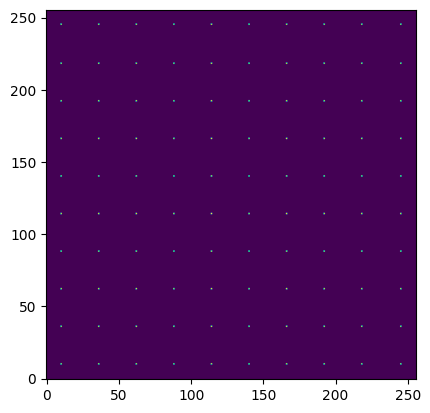

In [3]:
fig, ax = plt.subplots()
ax.imshow(img, origin='lower')
fig.show()

In [4]:
corners = calculate_covering(img_shape, psf_shape[0])

In [5]:
def elliptical_gaussian2d(x, y, height, cen_x, cen_y, sigma_x, sigma_y, rotation):
    a = np.square(np.cos(rotation)) / (2 * np.square(sigma_x)) + np.square(np.sin(rotation)) / (2 * np.square(sigma_y))
    b = - np.sin(2 * rotation) / (4 * np.square(sigma_x)) + np.sin(2 * rotation) / (4 * np.square(sigma_y))
    c = np.square(np.sin(rotation)) / (2 * np.square(sigma_x)) + np.square(np.cos(rotation)) / (2 * np.square(sigma_y))
    return height * np.exp(-(a * np.square(x - cen_x) + 2 * b * (x - cen_x) * (y - cen_y) + c * np.square(y - cen_y)))

def elongated_gaussian(x, y,
                       core_height, core_x, core_y, core_sigma,
                       tail_height, tail_x, tail_y, tail_sigma_x, tail_sigma_y, tail_rotation,
                       background):
    core = elliptical_gaussian2d(x, y, core_height, core_x, core_y, core_sigma, core_sigma, 0)
    tail = elliptical_gaussian2d(x, y, tail_height, tail_x, tail_y, tail_sigma_x, tail_sigma_y, tail_rotation)
    return core + tail + background


def punch_model(x, y):
    return {
        "core_height": 25,
        "core_x": 16,
        "core_y": 16,
        "core_sigma": 1,
        "tail_height": 8,
        "tail_x": 1.5 * np.cos(np.arctan2(y-img_shape[1]/2, x-img_shape[0]/2)+np.pi/2) + 16,
        "tail_y": 1.5 * np.sin(np.arctan2(y-img_shape[1]/2, x-img_shape[0]/2)+np.pi/2) + 16,
        "tail_sigma_x": 5,
        "tail_sigma_y": 1,
        "tail_rotation": np.arctan2(y-img_shape[1]/2, x-img_shape[0]/2), 
        "background": 0
    }

In [6]:
xarr, yarr = np.meshgrid(np.arange(psf_shape[0]), np.arange(psf_shape[1]))
apodization_window = np.sin((xarr + 0.5) * (np.pi / psf_shape[0])) * np.sin((yarr + 0.5) * (np.pi / psf_shape[1]))

/var/folders/w3/c3fpftqj0cn3zdjqpnn7ds31hdhdts/T/ipykernel_69860/3297512742.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


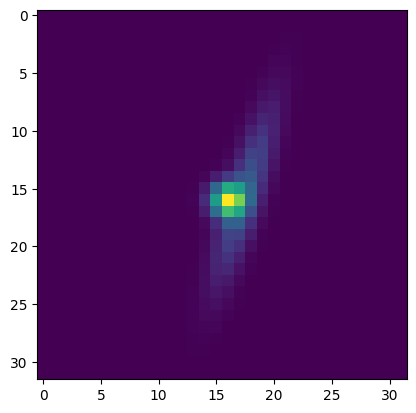

In [7]:
fig, ax = plt.subplots()
ax.imshow(elongated_gaussian(xarr, yarr, **punch_model(90, 0)))
fig.show()

In [8]:
pad_shape = ((psf_shape[0], psf_shape[0]), (psf_shape[1], psf_shape[1]))
img_p = np.pad(img, pad_shape, mode='constant')

observation_synthetic = np.zeros(img_shape)
observation_synthetic_p = np.pad(observation_synthetic, pad_shape)

def get_img_i(x, y):
    xs, xe, ys, ye = x+psf_shape[0], x+2*psf_shape[0], y+psf_shape[1], y+2*psf_shape[1]
    return img_p[xs:xe, ys:ye]

def set_synthetic_p(x, y, image):
    xs, xe, ys, ye = x+psf_shape[0], x+2*psf_shape[0], y+psf_shape[1], y+2*psf_shape[1]
    observation_synthetic_p[xs:xe, ys:ye] = np.nansum([image, observation_synthetic_p[xs:xe, ys:ye]], axis=0)

for x, y in corners:
    img_i = get_img_i(x, y)
    psf_i = elongated_gaussian(xarr, yarr, **punch_model(x, y))
    psf_i = psf_i / np.max(psf_i)
    out_i = np.real(ifftshift(ifft2(fft2(img_i*apodization_window) * fft2(psf_i)))) * apodization_window
    set_synthetic_p(x, y, out_i)
        
observation = observation_synthetic_p[psf_shape[0]:img_shape[0] + psf_shape[0], 
                                      psf_shape[1]:img_shape[1] + psf_shape[1]]
noise = np.random.randint(0, 5, observation.shape)
observation = observation# + noise

/var/folders/w3/c3fpftqj0cn3zdjqpnn7ds31hdhdts/T/ipykernel_69860/433395322.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


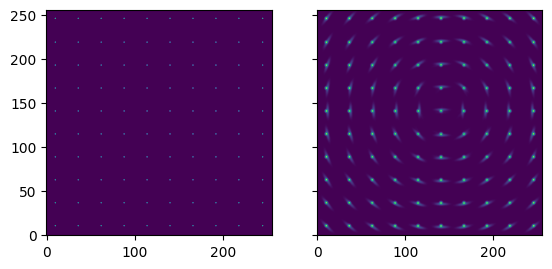

In [9]:
fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True)
axs[0].imshow(img, origin='lower')
axs[1].imshow(observation, origin='lower')
fig.show()

In [10]:
fwhm = 3

def general_gaussian2d(x,
                       y,
                       cen_x: float, cen_y: float,
                       a: float, b: float, c: float, height: float, background: float):
    """Creates a generalized 2D Gaussian

    Parameters
    ----------
    x
        first dimension input for Gaussian
    y
        second dimension input for Gaussian
    cen_x
        center of Gaussian in first dimension
    cen_y
        center of Gaussian in second dimension
    a
        general parameter for Gaussian, see notes
    b
        general parameter for Gaussian, see notes
    c
        general parameter for Gaussian, see notes
    height
        the maximum value of the Gaussian above the background
    background
        the lowest value of the Gaussian

    Returns
    -------
    float or np.ndarray
        the value of the Gaussian with the specified parameters at (x,y)
˚
    Notes
    -----
    .. math:: f(x,y)=A \exp(-{a(x-x_{0})^{2}+2b(x-x_{0})(y-y_{0})+c(y-y_{0})^{2}})

    See the section on the 2D Gaussian on wikipedia (https://en.wikipedia.org/wiki/Gaussian_function) for an
    interpretation of a, b, and c. In short, they boil down to incorporating sigma and a rotation angle.
    """
    return height * np.exp(
        -(a * np.square(x - cen_x)
          + 2 * b * (x - cen_x) * (y - cen_y)
          + c * np.square(y - cen_y))) + background
def interpretable_gaussian2d(x, y, height, cen_x, cen_y, sigma_x, sigma_y, rotation, background=0):
    a = np.square(np.cos(rotation)) / (2 * np.square(sigma_x)) + np.square(np.sin(rotation)) / (2 * np.square(sigma_y))
    b = - np.sin(2 * rotation) / (4 * np.square(sigma_x)) + np.sin(2 * rotation) / (4 * np.square(sigma_y))
    c = np.square(np.sin(rotation)) / (2 * np.square(sigma_x)) + np.square(np.cos(rotation)) / (2 * np.square(sigma_y))
    psf = general_gaussian2d(x, y, cen_x, cen_y, a, b, c, height, background)
    return psf
sigma = fwhm / np.sqrt(8 * np.log(2))
x, y = np.meshgrid(np.arange(psf_shape[0]), np.arange(psf_shape[1]))
final_psf = interpretable_gaussian2d(x, y, 1, psf_shape[0]/2-0.5, psf_shape[1]/2-0.5, sigma, sigma, 0)
final_psf = final_psf / np.max(final_psf)
final_psf_hat = fft2(final_psf)

In [11]:
psf_size = 32
corners = calculate_covering(observation.shape, psf_size)

corrector_dict = dict()
for x, y in corners:
    psf_i = elongated_gaussian(xarr, yarr, **punch_model(x, y))
    corrector_dict[(x, y)] = psf_i / np.max(psf_i)
corrector = ArrayCorrector(corrector_dict, final_psf)

In [12]:
corrected = corrector.correct_image(observation, alpha=3, epsilon=0.3)

In [13]:
padding_amount = (img_shape[0] - final_psf.shape[0])//2
final_psf_full_img = np.pad(final_psf, ((padding_amount, padding_amount), (padding_amount, padding_amount)))
final_psf_full_img_hat = fft2(np.pad(final_psf_full_img, ((img_shape[0]//2, img_shape[0]//2), (img_shape[0]//2, img_shape[0]//2))))
target = np.real(ifft2(fft2(np.pad(img, ((img_shape[0], 0), (img_shape[1], 0)))) * final_psf_full_img_hat))[:img_shape[0], :img_shape[1]]

/var/folders/w3/c3fpftqj0cn3zdjqpnn7ds31hdhdts/T/ipykernel_69860/3772805355.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


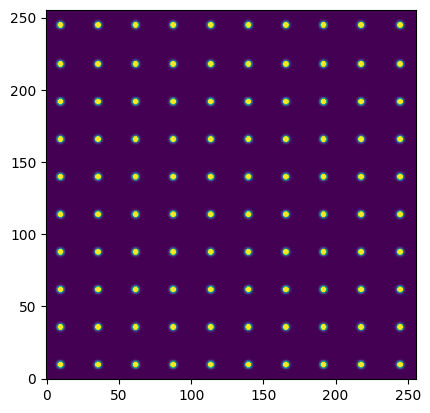

In [14]:
fig, ax = plt.subplots()
ax.imshow(target, origin='lower', vmin=0, vmax=5)
fig.show()

In [15]:
import matplotlib.colors as clr

a = np.linspace(0, 1, 1000)
r = np.sqrt(a)
g = a
b = np.square(a)
colors = np.stack([r, g, b], axis=-1)
custom = clr.ListedColormap(colors)

/var/folders/w3/c3fpftqj0cn3zdjqpnn7ds31hdhdts/T/ipykernel_69860/3985960407.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


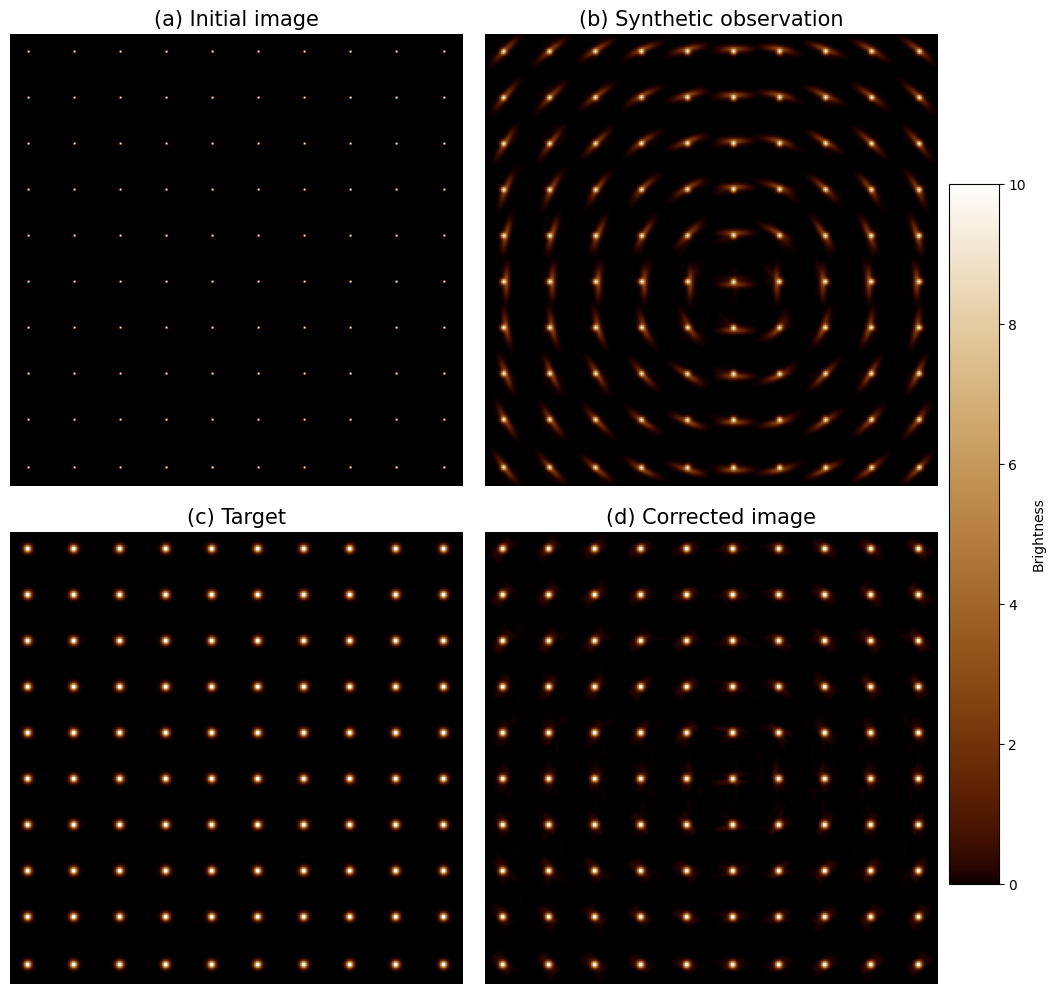

In [26]:
fig, axs = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True, figsize=(10, 10))
import matplotlib.pylab as pylab
params = {'axes.titlesize': 15}
pylab.rcParams.update(params)
vmin, vmax = 0, 10

axs[0, 0].imshow(img, cmap=custom, vmin=vmin, vmax=vmax)
axs[0, 0].set_title("(a) Initial image")
axs[0, 1].imshow(observation, cmap=custom, vmin=vmin, vmax=vmax)
axs[0, 1].set_title("(b) Synthetic observation")
axs[1, 1].imshow(corrected, cmap=custom, vmin=vmin, vmax=vmax)
axs[1,1].set_title("(d) Corrected image")
im = axs[1, 0].imshow(target, cmap=custom, vmin=vmin, vmax=vmax)
axs[1, 0].set_title("(c) Target")

for ax in axs.flatten():
    ax.set_axis_off()
    
cbar_ax = fig.add_axes([0.95, 0.1, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Brightness')
fig.subplots_adjust(wspace=0, hspace=0.1, left=0, right=0.95, bottom=0, top=0.95)

fig.savefig("../figures/model.png", bbox_inches='tight')
fig.show()